# Simple CNN for PETALO

Esta red la vamos a utilizar para obtener el radio 

In [1]:
import numpy as np
#np.random.seed(1337)  # for reproducibility
from time import time
from sklearn import preprocessing
import sys
print(sys.path)
sys.path.append("/home/rgadea/lmfit-py/")
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.callbacks import TensorBoard
from keras.utils import np_utils
from keras import regularizers
from math import floor
#from lmfit.models import  GaussianModel
import matplotlib.pyplot as plt

['', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python36.zip', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/lib-dynload', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/extensions', '/home/rgadea3/.ipython']


Using TensorFlow backend.


## Vamos introducir los datos de petalo preprocesados en matlab


In [2]:
import scipy.io as sio
import hdf5storage
datos_matlab = hdf5storage.loadmat('../datos_julio_2018/conjunto_entrenamiento_julio_2018_ring1y2_fil1.mat')
conjunto_datos= datos_matlab.get('photodefbox2_todoA')

## Network parameters:

In [3]:
use_regularizer = True
my_regularizer = None
my_epochs = 50
features_path = 'simple_autoe_features.pickle'
labels_path = 'simple_autoe_labels.pickle'

if use_regularizer:
    # add a sparsity constraint on the encoded representations
    # note use of 10e-5 leads to blurred results
    my_regularizer = regularizers.l2(0.001)
    # and a larger number of epochs as the added regularization the model
    # is less likely to overfit and can be trained longer
    my_epochs = 100
    features_path = 'sparse_autoe_features.pickle'
    labels_path = 'sparse_autoe_labels.pickle'

datos_matlab_encoder1 = hdf5storage.loadmat('../redes_compresoras/resultadoscompresores_1_medio_export.mat')
encoder_weights= datos_matlab_encoder1.get('encoder_weights')

    
    
encoding_dim = 240  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# input image dimensions
img_rows, img_cols = 16, 30
# this is our input placeholder
input_img = Input(shape=(480,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='sigmoid',activity_regularizer=regularizers.l2(0.0000001))(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(480, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction


autoencoder=Sequential([
    Dense(encoding_dim, kernel_regularizer=regularizers.l2(0.001), use_bias=True,bias_initializer='random_uniform',input_shape=(480,)),
    Activation('sigmoid'),
    Dense(480, use_bias=True,bias_initializer='random_uniform'),
    Activation('sigmoid'),
])

# autoencoder = Model(input_img, decoded)

## Prepare data into training and test set.

In [4]:
# the data, shuffled and split between train and test sets
# (X_train, y_train), (X_test, y_test) = mnist.load_data()
numero_muestras=conjunto_datos.shape[0]
print(numero_muestras)
print('conjunto_datos shape:', conjunto_datos.shape)

tr_size=60
val_size=20
test_size=100-val_size-tr_size

tamanyo_tr=floor(tr_size*numero_muestras/100)
tamanyo_val=floor(val_size*numero_muestras/100)
tamanyo_test=numero_muestras-tamanyo_tr-tamanyo_val
print(tamanyo_tr)
print(tamanyo_val)
print(tamanyo_test)


X_train=conjunto_datos[:tamanyo_tr,:]
X_val=conjunto_datos[tamanyo_tr:tamanyo_tr+tamanyo_val,:]
X_test=conjunto_datos[tamanyo_tr+tamanyo_val:numero_muestras,:]





Y_train=conjunto_datos[:tamanyo_tr,1] #elijo la coordenada radius
Y_val=conjunto_datos[tamanyo_tr:tamanyo_tr+tamanyo_val,1] #elijo la corrdenada radius
Y_test=conjunto_datos[tamanyo_tr+tamanyo_val:numero_muestras,1] #elijo la corrdenada radius

73588
conjunto_datos shape: (73588, 480)
44152
14717
14719


In [5]:
X_train = X_train.reshape(X_train.shape[0], img_cols, img_rows,1)
X_val = X_val.reshape(X_val.shape[0], img_cols, img_rows,1)
X_test = X_test.reshape(X_test.shape[0], img_cols, img_rows,1)


input_shape = (img_cols, img_rows,1)
#input_shape=input_shape.astype('int32')

In [6]:
X_train = X_train.astype('float32')
X_val= X_val.astype('float32')
X_test = X_test.astype('float32')

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

X_train shape: (44152, 30, 16, 1)
44152 train samples
14717 validation samples
14719 test samples


Display 20 random training images using image

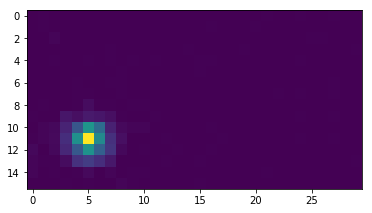

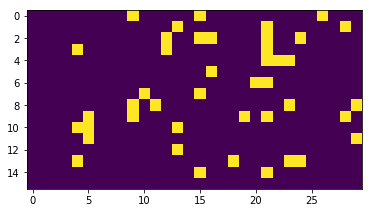

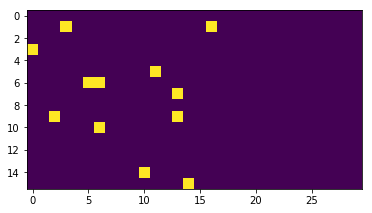

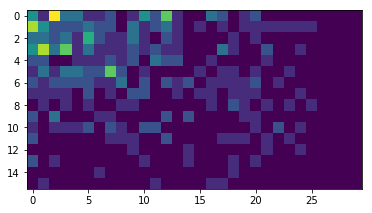

In [7]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,X_train.shape[0])
    plt.imshow(np.reshape(X_train[idea].transpose(), [16, 30]), cmap='viridis')
    plt.show()

Vamos a generar las matrices de datos para la red neuronal 

In [8]:
x_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
x_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(44152, 480)
(14719, 480)


Vamos a escalar entre 0 y 1

In [9]:
# min_max_scaler = preprocessing.QuantileTransformer().fit(x_train)
# min_max_scaler = preprocessing.MaxAbsScaler().fit(x_train)
# min_max_scaler = preprocessing.StandardScaler(with_mean=False).fit(x_train)
min_max_scaler = preprocessing.MinMaxScaler().fit(x_train)
# min_max_scaler = preprocessing.RobustScaler().fit(x_train)
x_train_min_max = min_max_scaler.transform(x_train)
x_test_min_max = min_max_scaler.transform(x_test)
min_max_scaler.data_max_

array([1132.,  434.,  187.,  418.,  493.,  370.,  823.,  244., 1100.,
       1041., 1432., 1237.,  541.,  511.,  191.,  433.,  330.,  583.,
        708.,  354.,  287.,  736.,  631.,  262.,  385.,  170.,  501.,
        801.,  835.,  264.,  226.,  218.,  840.,  137.,  751.,  179.,
        574.,  192.,  778.,  441.,  509.,  305.,  306.,  517.,  364.,
        519.,  568.,  427.,  398., 1576., 1467., 1462.,  283.,  123.,
        372.,  333.,  408.,  130.,  775.,  511.,  577.,  158.,  237.,
        390., 1443.,  238., 1273.,  231.,  468.,  430.,  329.,  381.,
        406.,  573., 1165.,  265.,  202.,  327.,  172., 1018., 1558.,
        368.,  527.,  537.,  474.,  256.,  402.,  365.,  827.,  301.,
        167.,  332.,  345.,  734.,  406.,  128.,  801.,  395.,  258.,
        481., 1005.,  624., 1170.,  256.,  347.,  491.,  569.,  468.,
       1444.,  258.,  196.,  196.,  542.,  452., 1028.,  403.,  661.,
        725.,  505.,  294.,  404.,  527.,  999.,  268.,  258.,  231.,
        191.,  169.,

## Build the CNN. 

In [10]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='sgd', loss='mse')



Show a summary of the model parameters. 

And now train the model and evaluate on the test set. 

In [11]:
tensorboard=TensorBoard(log_dir="/home/rgadea3/EXPERIMENTOS/nuevas_investigaciones_2018/experimentos/logs/{}".format(time()))
autoencoder.fit(x_train_min_max, x_train_min_max,
                epochs=5000,
                batch_size=500,
                shuffle=False,
                callbacks=[tensorboard],
                validation_data=(x_test_min_max, x_test_min_max))



Train on 44152 samples, validate on 14719 samples
Epoch 1/5000
44152/44152 [==============================] - 1s 21us/step - loss: 0.5707 - val_loss: 0.5670
Epoch 2/5000
44152/44152 [==============================] - 1s 16us/step - loss: 0.5631 - val_loss: 0.5594
Epoch 3/5000
44152/44152 [==============================] - 1s 15us/step - loss: 0.5557 - val_loss: 0.5520
Epoch 4/5000
44152/44152 [==============================] - 1s 14us/step - loss: 0.5483 - val_loss: 0.5448
Epoch 5/5000
44152/44152 [==============================] - 1s 13us/step - loss: 0.5412 - val_loss: 0.5377
Epoch 6/5000
44152/44152 [==============================] - 1s 12us/step - loss: 0.5342 - val_loss: 0.5308
Epoch 7/5000
44152/44152 [==============================] - 1s 14us/step - loss: 0.5273 - val_loss: 0.5240
Epoch 8/5000
44152/44152 [==============================] - 1s 12us/step - loss: 0.5206 - val_loss: 0.5173
Epoch 9/5000
44152/44152 [==============================] - 1s 16us/step - loss: 0.5140 - val_

44152/44152 [==============================] - 0s 11us/step - loss: 0.2957 - val_loss: 0.2950
Epoch 77/5000
44152/44152 [==============================] - 1s 12us/step - loss: 0.2941 - val_loss: 0.2934
Epoch 78/5000
44152/44152 [==============================] - 1s 14us/step - loss: 0.2925 - val_loss: 0.2919
Epoch 79/5000
44152/44152 [==============================] - 1s 17us/step - loss: 0.2910 - val_loss: 0.2903
Epoch 80/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.2894 - val_loss: 0.2888
Epoch 81/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.2879 - val_loss: 0.2873
Epoch 82/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.2864 - val_loss: 0.2858
Epoch 83/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.2850 - val_loss: 0.2843
Epoch 84/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.2835 - val_loss: 0.2829
Epoch 85/5000
44152/44152 [===============

44152/44152 [==============================] - 1s 14us/step - loss: 0.2106 - val_loss: 0.2103
Epoch 152/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.2098 - val_loss: 0.2095
Epoch 153/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.2089 - val_loss: 0.2086
Epoch 154/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.2081 - val_loss: 0.2078
Epoch 155/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.2073 - val_loss: 0.2070
Epoch 156/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.2064 - val_loss: 0.2061
Epoch 157/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.2056 - val_loss: 0.2053
Epoch 158/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.2048 - val_loss: 0.2045
Epoch 159/5000
44152/44152 [==============================] - 1s 21us/step - loss: 0.2040 - val_loss: 0.2037
Epoch 160/5000
44152/44152 [======

44152/44152 [==============================] - 1s 14us/step - loss: 0.1579 - val_loss: 0.1577
Epoch 227/5000
44152/44152 [==============================] - 1s 18us/step - loss: 0.1573 - val_loss: 0.1571
Epoch 228/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.1567 - val_loss: 0.1565
Epoch 229/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.1561 - val_loss: 0.1560
Epoch 230/5000
44152/44152 [==============================] - 1s 18us/step - loss: 0.1556 - val_loss: 0.1554
Epoch 231/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.1550 - val_loss: 0.1548
Epoch 232/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.1544 - val_loss: 0.1542
Epoch 233/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.1538 - val_loss: 0.1537
Epoch 234/5000
44152/44152 [==============================] - 1s 17us/step - loss: 0.1533 - val_loss: 0.1531
Epoch 235/5000
44152/44152 [======

44152/44152 [==============================] - 1s 20us/step - loss: 0.1201 - val_loss: 0.1200
Epoch 302/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.1197 - val_loss: 0.1196
Epoch 303/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.1192 - val_loss: 0.1192
Epoch 304/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.1188 - val_loss: 0.1187
Epoch 305/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.1184 - val_loss: 0.1183
Epoch 306/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.1180 - val_loss: 0.1179
Epoch 307/5000
44152/44152 [==============================] - 1s 18us/step - loss: 0.1175 - val_loss: 0.1175
Epoch 308/5000
44152/44152 [==============================] - 1s 15us/step - loss: 0.1171 - val_loss: 0.1170
Epoch 309/5000
44152/44152 [==============================] - 1s 16us/step - loss: 0.1167 - val_loss: 0.1166
Epoch 310/5000
44152/44152 [======

44152/44152 [==============================] - 1s 20us/step - loss: 0.0920 - val_loss: 0.0920
Epoch 377/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0917 - val_loss: 0.0916
Epoch 378/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0913 - val_loss: 0.0913
Epoch 379/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0910 - val_loss: 0.0910
Epoch 380/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0907 - val_loss: 0.0907
Epoch 381/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0904 - val_loss: 0.0904
Epoch 382/5000
44152/44152 [==============================] - 1s 16us/step - loss: 0.0901 - val_loss: 0.0900
Epoch 383/5000
44152/44152 [==============================] - 1s 17us/step - loss: 0.0897 - val_loss: 0.0897
Epoch 384/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0894 - val_loss: 0.0894
Epoch 385/5000
44152/44152 [======

44152/44152 [==============================] - 1s 18us/step - loss: 0.0708 - val_loss: 0.0708
Epoch 452/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0705 - val_loss: 0.0705
Epoch 453/5000
44152/44152 [==============================] - ETA: 0s - loss: 0.070 - 1s 20us/step - loss: 0.0703 - val_loss: 0.0703
Epoch 454/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0700 - val_loss: 0.0700
Epoch 455/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0698 - val_loss: 0.0698
Epoch 456/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0695 - val_loss: 0.0695
Epoch 457/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0693 - val_loss: 0.0693
Epoch 458/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0691 - val_loss: 0.0691
Epoch 459/5000
44152/44152 [==============================] - 1s 15us/step - loss: 0.0688 - val_loss: 0.0688
Epoch 460/

44152/44152 [==============================] - 1s 19us/step - loss: 0.0546 - val_loss: 0.0546
Epoch 527/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0544 - val_loss: 0.0545
Epoch 528/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0542 - val_loss: 0.0543
Epoch 529/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0540 - val_loss: 0.0541
Epoch 530/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0539 - val_loss: 0.0539
Epoch 531/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0537 - val_loss: 0.0537
Epoch 532/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0535 - val_loss: 0.0535
Epoch 533/5000
44152/44152 [==============================] - 1s 15us/step - loss: 0.0533 - val_loss: 0.0534
Epoch 534/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0531 - val_loss: 0.0532
Epoch 535/5000
44152/44152 [======

44152/44152 [==============================] - 1s 19us/step - loss: 0.0423 - val_loss: 0.0423
Epoch 602/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0421 - val_loss: 0.0422
Epoch 603/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0420 - val_loss: 0.0421
Epoch 604/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0419 - val_loss: 0.0419
Epoch 605/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0417 - val_loss: 0.0418
Epoch 606/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0416 - val_loss: 0.0416
Epoch 607/5000
44152/44152 [==============================] - 1s 18us/step - loss: 0.0414 - val_loss: 0.0415
Epoch 608/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0413 - val_loss: 0.0414
Epoch 609/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0412 - val_loss: 0.0412
Epoch 610/5000
44152/44152 [======

44152/44152 [==============================] - 1s 20us/step - loss: 0.0329 - val_loss: 0.0329
Epoch 677/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0327 - val_loss: 0.0328
Epoch 678/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0326 - val_loss: 0.0327
Epoch 679/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0325 - val_loss: 0.0326
Epoch 680/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0324 - val_loss: 0.0325
Epoch 681/5000
44152/44152 [==============================] - 1s 17us/step - loss: 0.0323 - val_loss: 0.0324
Epoch 682/5000
44152/44152 [==============================] - 1s 15us/step - loss: 0.0322 - val_loss: 0.0323
Epoch 683/5000
44152/44152 [==============================] - 1s 18us/step - loss: 0.0321 - val_loss: 0.0322
Epoch 684/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0320 - val_loss: 0.0321
Epoch 685/5000
44152/44152 [======

44152/44152 [==============================] - 1s 20us/step - loss: 0.0256 - val_loss: 0.0257
Epoch 752/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0255 - val_loss: 0.0256
Epoch 753/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0255 - val_loss: 0.0256
Epoch 754/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0254 - val_loss: 0.0255
Epoch 755/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0253 - val_loss: 0.0254
Epoch 756/5000
44152/44152 [==============================] - 1s 17us/step - loss: 0.0252 - val_loss: 0.0253
Epoch 757/5000
44152/44152 [==============================] - 1s 18us/step - loss: 0.0251 - val_loss: 0.0252
Epoch 758/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0250 - val_loss: 0.0251
Epoch 759/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0250 - val_loss: 0.0251
Epoch 760/5000
44152/44152 [======

44152/44152 [==============================] - 1s 19us/step - loss: 0.0201 - val_loss: 0.0202
Epoch 827/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0200 - val_loss: 0.0201
Epoch 828/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0199 - val_loss: 0.0201
Epoch 829/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0199 - val_loss: 0.0200
Epoch 830/5000
44152/44152 [==============================] - 1s 18us/step - loss: 0.0198 - val_loss: 0.0199
Epoch 831/5000
44152/44152 [==============================] - 1s 16us/step - loss: 0.0198 - val_loss: 0.0199
Epoch 832/5000
44152/44152 [==============================] - 1s 18us/step - loss: 0.0197 - val_loss: 0.0198
Epoch 833/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0196 - val_loss: 0.0197
Epoch 834/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0196 - val_loss: 0.0197
Epoch 835/5000
44152/44152 [======

44152/44152 [==============================] - 1s 20us/step - loss: 0.0158 - val_loss: 0.0159
Epoch 902/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0158 - val_loss: 0.0159
Epoch 903/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0157 - val_loss: 0.0158
Epoch 904/5000
44152/44152 [==============================] - 1s 21us/step - loss: 0.0157 - val_loss: 0.0158
Epoch 905/5000
44152/44152 [==============================] - 1s 16us/step - loss: 0.0156 - val_loss: 0.0157
Epoch 906/5000
44152/44152 [==============================] - 1s 18us/step - loss: 0.0156 - val_loss: 0.0157
Epoch 907/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0155 - val_loss: 0.0156
Epoch 908/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0155 - val_loss: 0.0156
Epoch 909/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0154 - val_loss: 0.0155
Epoch 910/5000
44152/44152 [======

44152/44152 [==============================] - 1s 20us/step - loss: 0.0125 - val_loss: 0.0126
Epoch 977/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0125 - val_loss: 0.0126
Epoch 978/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0124 - val_loss: 0.0126
Epoch 979/5000
44152/44152 [==============================] - 1s 15us/step - loss: 0.0124 - val_loss: 0.0125
Epoch 980/5000
44152/44152 [==============================] - 1s 17us/step - loss: 0.0124 - val_loss: 0.0125
Epoch 981/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0123 - val_loss: 0.0124
Epoch 982/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0123 - val_loss: 0.0124
Epoch 983/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0123 - val_loss: 0.0124
Epoch 984/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0122 - val_loss: 0.0123
Epoch 985/5000
44152/44152 [======

Epoch 1051/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0100 - val_loss: 0.0101
Epoch 1052/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0100 - val_loss: 0.0101
Epoch 1053/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0099 - val_loss: 0.0100
Epoch 1054/5000
44152/44152 [==============================] - 1s 17us/step - loss: 0.0099 - val_loss: 0.0100
Epoch 1055/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0099 - val_loss: 0.0100
Epoch 1056/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0098 - val_loss: 0.0100
Epoch 1057/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0098 - val_loss: 0.0099
Epoch 1058/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0098 - val_loss: 0.0099
Epoch 1059/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0097 - val_loss: 0.0099
Epoch 1060

44152/44152 [==============================] - 1s 19us/step - loss: 0.0080 - val_loss: 0.0082
Epoch 1126/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0080 - val_loss: 0.0081
Epoch 1127/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0080 - val_loss: 0.0081
Epoch 1128/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0080 - val_loss: 0.0081
Epoch 1129/5000
44152/44152 [==============================] - 1s 17us/step - loss: 0.0080 - val_loss: 0.0081
Epoch 1130/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0079 - val_loss: 0.0081
Epoch 1131/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0079 - val_loss: 0.0080
Epoch 1132/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0079 - val_loss: 0.0080
Epoch 1133/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0079 - val_loss: 0.0080
Epoch 1134/5000
44152/4415

44152/44152 [==============================] - 1s 20us/step - loss: 0.0065 - val_loss: 0.0067
Epoch 1200/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0065 - val_loss: 0.0066
Epoch 1201/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0065 - val_loss: 0.0066
Epoch 1202/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0065 - val_loss: 0.0066
Epoch 1203/5000
44152/44152 [==============================] - 1s 15us/step - loss: 0.0065 - val_loss: 0.0066
Epoch 1204/5000
44152/44152 [==============================] - 1s 17us/step - loss: 0.0064 - val_loss: 0.0066
Epoch 1205/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0064 - val_loss: 0.0066
Epoch 1206/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0064 - val_loss: 0.0065
Epoch 1207/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0064 - val_loss: 0.0065
Epoch 1208/5000
44152/4415

44152/44152 [==============================] - 1s 20us/step - loss: 0.0054 - val_loss: 0.0055
Epoch 1274/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0054 - val_loss: 0.0055
Epoch 1275/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0053 - val_loss: 0.0055
Epoch 1276/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0053 - val_loss: 0.0055
Epoch 1277/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0053 - val_loss: 0.0054
Epoch 1278/5000
44152/44152 [==============================] - 1s 18us/step - loss: 0.0053 - val_loss: 0.0054
Epoch 1279/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0053 - val_loss: 0.0054
Epoch 1280/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0053 - val_loss: 0.0054
Epoch 1281/5000
44152/44152 [==============================] - 1s 18us/step - loss: 0.0053 - val_loss: 0.0054
Epoch 1282/5000
44152/4415

44152/44152 [==============================] - 1s 20us/step - loss: 0.0045 - val_loss: 0.0046
Epoch 1348/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0044 - val_loss: 0.0046
Epoch 1349/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0044 - val_loss: 0.0046
Epoch 1350/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0044 - val_loss: 0.0046
Epoch 1351/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0044 - val_loss: 0.0045
Epoch 1352/5000
44152/44152 [==============================] - 1s 15us/step - loss: 0.0044 - val_loss: 0.0045
Epoch 1353/5000
44152/44152 [==============================] - 1s 18us/step - loss: 0.0044 - val_loss: 0.0045
Epoch 1354/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0044 - val_loss: 0.0045
Epoch 1355/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0044 - val_loss: 0.0045
Epoch 1356/5000
44152/4415

44152/44152 [==============================] - 1s 16us/step - loss: 0.0037 - val_loss: 0.0039
Epoch 1422/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0037 - val_loss: 0.0039
Epoch 1423/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0037 - val_loss: 0.0038
Epoch 1424/5000
44152/44152 [==============================] - 1s 16us/step - loss: 0.0037 - val_loss: 0.0038
Epoch 1425/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0037 - val_loss: 0.0038
Epoch 1426/5000
44152/44152 [==============================] - 1s 18us/step - loss: 0.0037 - val_loss: 0.0038
Epoch 1427/5000
44152/44152 [==============================] - 1s 17us/step - loss: 0.0037 - val_loss: 0.0038
Epoch 1428/5000
44152/44152 [==============================] - 1s 18us/step - loss: 0.0037 - val_loss: 0.0038
Epoch 1429/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0037 - val_loss: 0.0038
Epoch 1430/5000
44152/4415

44152/44152 [==============================] - 1s 20us/step - loss: 0.0032 - val_loss: 0.0033
Epoch 1496/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0032 - val_loss: 0.0033
Epoch 1497/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0032 - val_loss: 0.0033
Epoch 1498/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0032 - val_loss: 0.0033
Epoch 1499/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0031 - val_loss: 0.0033
Epoch 1500/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0031 - val_loss: 0.0033
Epoch 1501/5000
44152/44152 [==============================] - 1s 16us/step - loss: 0.0031 - val_loss: 0.0033
Epoch 1502/5000
44152/44152 [==============================] - 1s 16us/step - loss: 0.0031 - val_loss: 0.0033
Epoch 1503/5000
44152/44152 [==============================] - 1s 18us/step - loss: 0.0031 - val_loss: 0.0033
Epoch 1504/5000
44152/4415

44152/44152 [==============================] - 1s 20us/step - loss: 0.0027 - val_loss: 0.0029
Epoch 1570/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0027 - val_loss: 0.0029
Epoch 1571/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0027 - val_loss: 0.0029
Epoch 1572/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0027 - val_loss: 0.0028
Epoch 1573/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0027 - val_loss: 0.0028
Epoch 1574/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0027 - val_loss: 0.0028
Epoch 1575/5000
44152/44152 [==============================] - 1s 18us/step - loss: 0.0027 - val_loss: 0.0028
Epoch 1576/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0027 - val_loss: 0.0028
Epoch 1577/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0027 - val_loss: 0.0028
Epoch 1578/5000
44152/4415

44152/44152 [==============================] - 1s 20us/step - loss: 0.0024 - val_loss: 0.0025
Epoch 1644/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0024 - val_loss: 0.0025
Epoch 1645/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0024 - val_loss: 0.0025
Epoch 1646/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0024 - val_loss: 0.0025
Epoch 1647/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0024 - val_loss: 0.0025
Epoch 1648/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0024 - val_loss: 0.0025
Epoch 1649/5000
44152/44152 [==============================] - 1s 16us/step - loss: 0.0023 - val_loss: 0.0025
Epoch 1650/5000
44152/44152 [==============================] - 1s 18us/step - loss: 0.0023 - val_loss: 0.0025
Epoch 1651/5000
44152/44152 [==============================] - 1s 18us/step - loss: 0.0023 - val_loss: 0.0025
Epoch 1652/5000
44152/4415

44152/44152 [==============================] - 1s 19us/step - loss: 0.0021 - val_loss: 0.0022
Epoch 1718/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0021 - val_loss: 0.0022
Epoch 1719/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0021 - val_loss: 0.0022
Epoch 1720/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0021 - val_loss: 0.0022
Epoch 1721/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0021 - val_loss: 0.0022
Epoch 1722/5000
44152/44152 [==============================] - 1s 21us/step - loss: 0.0021 - val_loss: 0.0022
Epoch 1723/5000
44152/44152 [==============================] - 1s 15us/step - loss: 0.0021 - val_loss: 0.0022
Epoch 1724/5000
44152/44152 [==============================] - 1s 17us/step - loss: 0.0021 - val_loss: 0.0022
Epoch 1725/5000
44152/44152 [==============================] - 1s 18us/step - loss: 0.0021 - val_loss: 0.0022
Epoch 1726/5000
44152/4415

44152/44152 [==============================] - 1s 20us/step - loss: 0.0019 - val_loss: 0.0020
Epoch 1792/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0019 - val_loss: 0.0020
Epoch 1793/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0019 - val_loss: 0.0020
Epoch 1794/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0019 - val_loss: 0.0020
Epoch 1795/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0019 - val_loss: 0.0020
Epoch 1796/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0019 - val_loss: 0.0020
Epoch 1797/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0018 - val_loss: 0.0020
Epoch 1798/5000
44152/44152 [==============================] - 1s 16us/step - loss: 0.0018 - val_loss: 0.0020
Epoch 1799/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0018 - val_loss: 0.0020
Epoch 1800/5000
44152/4415

44152/44152 [==============================] - 1s 20us/step - loss: 0.0017 - val_loss: 0.0018
Epoch 1866/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0017 - val_loss: 0.0018
Epoch 1867/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0017 - val_loss: 0.0018
Epoch 1868/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0017 - val_loss: 0.0018
Epoch 1869/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0017 - val_loss: 0.0018
Epoch 1870/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0017 - val_loss: 0.0018
Epoch 1871/5000
44152/44152 [==============================] - 1s 18us/step - loss: 0.0017 - val_loss: 0.0018
Epoch 1872/5000
44152/44152 [==============================] - 1s 16us/step - loss: 0.0017 - val_loss: 0.0018
Epoch 1873/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0017 - val_loss: 0.0018
Epoch 1874/5000
44152/4415

44152/44152 [==============================] - 1s 20us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 1940/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 1941/5000
44152/44152 [==============================] - 1s 18us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 1942/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 1943/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 1944/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 1945/5000
44152/44152 [==============================] - 1s 17us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 1946/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 1947/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 1948/5000
44152/4415

44152/44152 [==============================] - 1s 20us/step - loss: 0.0014 - val_loss: 0.0016
Epoch 2014/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0014 - val_loss: 0.0016
Epoch 2015/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0014 - val_loss: 0.0015
Epoch 2016/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0014 - val_loss: 0.0015
Epoch 2017/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0014 - val_loss: 0.0015
Epoch 2018/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0014 - val_loss: 0.0015
Epoch 2019/5000
44152/44152 [==============================] - 1s 18us/step - loss: 0.0014 - val_loss: 0.0015
Epoch 2020/5000
44152/44152 [==============================] - 1s 16us/step - loss: 0.0014 - val_loss: 0.0015
Epoch 2021/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0014 - val_loss: 0.0015
Epoch 2022/5000
44152/4415

44152/44152 [==============================] - 1s 20us/step - loss: 0.0013 - val_loss: 0.0015
Epoch 2088/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0013 - val_loss: 0.0015
Epoch 2089/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0013 - val_loss: 0.0015
Epoch 2090/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 2091/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 2092/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 2093/5000
44152/44152 [==============================] - 1s 16us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 2094/5000
44152/44152 [==============================] - 1s 14us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 2095/5000
44152/44152 [==============================] - 1s 14us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 2096/5000
44152/4415

44152/44152 [==============================] - 1s 20us/step - loss: 0.0012 - val_loss: 0.0014
Epoch 2162/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0012 - val_loss: 0.0014
Epoch 2163/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0012 - val_loss: 0.0014
Epoch 2164/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0012 - val_loss: 0.0014
Epoch 2165/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0012 - val_loss: 0.0014
Epoch 2166/5000
44152/44152 [==============================] - 1s 17us/step - loss: 0.0012 - val_loss: 0.0014
Epoch 2167/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0012 - val_loss: 0.0014
Epoch 2168/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0012 - val_loss: 0.0014
Epoch 2169/5000
44152/44152 [==============================] - 1s 15us/step - loss: 0.0012 - val_loss: 0.0014
Epoch 2170/5000
44152/4415

44152/44152 [==============================] - 1s 20us/step - loss: 0.0012 - val_loss: 0.0013
Epoch 2236/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0012 - val_loss: 0.0013
Epoch 2237/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0012 - val_loss: 0.0013
Epoch 2238/5000
44152/44152 [==============================] - 1s 18us/step - loss: 0.0012 - val_loss: 0.0013
Epoch 2239/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0012 - val_loss: 0.0013
Epoch 2240/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0012 - val_loss: 0.0013
Epoch 2241/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0012 - val_loss: 0.0013
Epoch 2242/5000
44152/44152 [==============================] - 1s 14us/step - loss: 0.0012 - val_loss: 0.0013
Epoch 2243/5000
44152/44152 [==============================] - 1s 16us/step - loss: 0.0012 - val_loss: 0.0013
Epoch 2244/5000
44152/4415

44152/44152 [==============================] - 1s 19us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 2310/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 2311/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 2312/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 2313/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 2314/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 2315/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 2316/5000
44152/44152 [==============================] - 1s 17us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 2317/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 2318/5000
44152/4415

44152/44152 [==============================] - 1s 20us/step - loss: 0.0010 - val_loss: 0.0012
Epoch 2384/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0010 - val_loss: 0.0012
Epoch 2385/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0010 - val_loss: 0.0012
Epoch 2386/5000
44152/44152 [==============================] - 1s 20us/step - loss: 0.0010 - val_loss: 0.0012
Epoch 2387/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0010 - val_loss: 0.0012
Epoch 2388/5000
44152/44152 [==============================] - 1s 19us/step - loss: 0.0010 - val_loss: 0.0012
Epoch 2389/5000
44152/44152 [==============================] - 1s 21us/step - loss: 0.0010 - val_loss: 0.0012
Epoch 2390/5000
44152/44152 [==============================] - 1s 15us/step - loss: 0.0010 - val_loss: 0.0012
Epoch 2391/5000
44152/44152 [==============================] - 1s 17us/step - loss: 0.0010 - val_loss: 0.0012
Epoch 2392/5000
44152/4415

44152/44152 [==============================] - 1s 19us/step - loss: 9.9822e-04 - val_loss: 0.0011
Epoch 2458/5000
44152/44152 [==============================] - 1s 20us/step - loss: 9.9764e-04 - val_loss: 0.0011
Epoch 2459/5000
44152/44152 [==============================] - 1s 20us/step - loss: 9.9706e-04 - val_loss: 0.0011
Epoch 2460/5000
44152/44152 [==============================] - 1s 20us/step - loss: 9.9649e-04 - val_loss: 0.0011
Epoch 2461/5000
44152/44152 [==============================] - 1s 20us/step - loss: 9.9591e-04 - val_loss: 0.0011
Epoch 2462/5000
44152/44152 [==============================] - 1s 20us/step - loss: 9.9534e-04 - val_loss: 0.0011
Epoch 2463/5000
44152/44152 [==============================] - 1s 20us/step - loss: 9.9477e-04 - val_loss: 0.0011
Epoch 2464/5000
44152/44152 [==============================] - 1s 18us/step - loss: 9.9419e-04 - val_loss: 0.0011
Epoch 2465/5000
44152/44152 [==============================] - 1s 17us/step - loss: 9.9362e-04 - val_los

44152/44152 [==============================] - 1s 13us/step - loss: 9.5946e-04 - val_loss: 0.0011
Epoch 2530/5000
44152/44152 [==============================] - 1s 16us/step - loss: 9.5896e-04 - val_loss: 0.0011
Epoch 2531/5000
44152/44152 [==============================] - 1s 19us/step - loss: 9.5846e-04 - val_loss: 0.0011
Epoch 2532/5000
44152/44152 [==============================] - 1s 20us/step - loss: 9.5796e-04 - val_loss: 0.0011
Epoch 2533/5000
44152/44152 [==============================] - 1s 19us/step - loss: 9.5746e-04 - val_loss: 0.0011
Epoch 2534/5000
44152/44152 [==============================] - 1s 19us/step - loss: 9.5697e-04 - val_loss: 0.0011
Epoch 2535/5000
44152/44152 [==============================] - 1s 20us/step - loss: 9.5647e-04 - val_loss: 0.0011
Epoch 2536/5000
44152/44152 [==============================] - 1s 20us/step - loss: 9.5597e-04 - val_loss: 0.0011
Epoch 2537/5000
44152/44152 [==============================] - 1s 20us/step - loss: 9.5548e-04 - val_los

44152/44152 [==============================] - 1s 12us/step - loss: 9.2541e-04 - val_loss: 0.0011
Epoch 2602/5000
44152/44152 [==============================] - 1s 14us/step - loss: 9.2496e-04 - val_loss: 0.0011
Epoch 2603/5000
44152/44152 [==============================] - 1s 17us/step - loss: 9.2451e-04 - val_loss: 0.0011
Epoch 2604/5000
44152/44152 [==============================] - 1s 19us/step - loss: 9.2406e-04 - val_loss: 0.0011
Epoch 2605/5000
44152/44152 [==============================] - 1s 20us/step - loss: 9.2362e-04 - val_loss: 0.0011
Epoch 2606/5000
44152/44152 [==============================] - 1s 20us/step - loss: 9.2317e-04 - val_loss: 0.0011
Epoch 2607/5000
44152/44152 [==============================] - 1s 19us/step - loss: 9.2273e-04 - val_loss: 0.0011
Epoch 2608/5000
44152/44152 [==============================] - 1s 20us/step - loss: 9.2228e-04 - val_loss: 0.0011
Epoch 2609/5000
44152/44152 [==============================] - 1s 20us/step - loss: 9.2184e-04 - val_los

44152/44152 [==============================] - 1s 20us/step - loss: 8.9468e-04 - val_loss: 0.0010
Epoch 2674/5000
44152/44152 [==============================] - 1s 20us/step - loss: 8.9427e-04 - val_loss: 0.0010
Epoch 2675/5000
44152/44152 [==============================] - 1s 19us/step - loss: 8.9387e-04 - val_loss: 0.0010
Epoch 2676/5000
44152/44152 [==============================] - 0s 10us/step - loss: 8.9346e-04 - val_loss: 0.0010
Epoch 2677/5000
44152/44152 [==============================] - 0s 11us/step - loss: 8.9306e-04 - val_loss: 0.0010
Epoch 2678/5000
44152/44152 [==============================] - 1s 12us/step - loss: 8.9266e-04 - val_loss: 0.0010
Epoch 2679/5000
44152/44152 [==============================] - 1s 14us/step - loss: 8.9225e-04 - val_loss: 0.0010
Epoch 2680/5000
44152/44152 [==============================] - 1s 15us/step - loss: 8.9185e-04 - val_loss: 0.0010
Epoch 2681/5000
44152/44152 [==============================] - 1s 18us/step - loss: 8.9145e-04 - val_los

44152/44152 [==============================] - 1s 16us/step - loss: 8.6688e-04 - val_loss: 0.0010
Epoch 2746/5000
44152/44152 [==============================] - 1s 20us/step - loss: 8.6651e-04 - val_loss: 0.0010
Epoch 2747/5000
44152/44152 [==============================] - 1s 20us/step - loss: 8.6614e-04 - val_loss: 0.0010
Epoch 2748/5000
44152/44152 [==============================] - 1s 20us/step - loss: 8.6578e-04 - val_loss: 0.0010
Epoch 2749/5000
44152/44152 [==============================] - 1s 12us/step - loss: 8.6541e-04 - val_loss: 0.0010
Epoch 2750/5000
44152/44152 [==============================] - 0s 11us/step - loss: 8.6505e-04 - val_loss: 0.0010
Epoch 2751/5000
44152/44152 [==============================] - 1s 11us/step - loss: 8.6469e-04 - val_loss: 0.0010
Epoch 2752/5000
44152/44152 [==============================] - 1s 13us/step - loss: 8.6432e-04 - val_loss: 0.0010
Epoch 2753/5000
44152/44152 [==============================] - 1s 16us/step - loss: 8.6396e-04 - val_los

Epoch 2815/5000
44152/44152 [==============================] - 1s 20us/step - loss: 8.4239e-04 - val_loss: 9.7955e-04
Epoch 2816/5000
44152/44152 [==============================] - 1s 19us/step - loss: 8.4205e-04 - val_loss: 9.7922e-04
Epoch 2817/5000
44152/44152 [==============================] - 1s 20us/step - loss: 8.4172e-04 - val_loss: 9.7888e-04
Epoch 2818/5000
44152/44152 [==============================] - 1s 16us/step - loss: 8.4138e-04 - val_loss: 9.7855e-04
Epoch 2819/5000
44152/44152 [==============================] - 1s 19us/step - loss: 8.4105e-04 - val_loss: 9.7822e-04
Epoch 2820/5000
44152/44152 [==============================] - 1s 20us/step - loss: 8.4072e-04 - val_loss: 9.7788e-04
Epoch 2821/5000
44152/44152 [==============================] - 1s 20us/step - loss: 8.4038e-04 - val_loss: 9.7755e-04
Epoch 2822/5000
44152/44152 [==============================] - 1s 21us/step - loss: 8.4005e-04 - val_loss: 9.7722e-04
Epoch 2823/5000
44152/44152 [===========================

44152/44152 [==============================] - 1s 20us/step - loss: 8.2010e-04 - val_loss: 9.5728e-04
Epoch 2885/5000
44152/44152 [==============================] - 1s 20us/step - loss: 8.1979e-04 - val_loss: 9.5697e-04
Epoch 2886/5000
44152/44152 [==============================] - 1s 19us/step - loss: 8.1947e-04 - val_loss: 9.5666e-04
Epoch 2887/5000
44152/44152 [==============================] - 1s 19us/step - loss: 8.1916e-04 - val_loss: 9.5635e-04
Epoch 2888/5000
44152/44152 [==============================] - 1s 20us/step - loss: 8.1885e-04 - val_loss: 9.5604e-04
Epoch 2889/5000
44152/44152 [==============================] - 1s 20us/step - loss: 8.1854e-04 - val_loss: 9.5573e-04
Epoch 2890/5000
44152/44152 [==============================] - 1s 19us/step - loss: 8.1823e-04 - val_loss: 9.5542e-04
Epoch 2891/5000
44152/44152 [==============================] - 1s 17us/step - loss: 8.1792e-04 - val_loss: 9.5511e-04
Epoch 2892/5000
44152/44152 [==============================] - 1s 16us/s

44152/44152 [==============================] - 1s 20us/step - loss: 7.9923e-04 - val_loss: 9.3643e-04
Epoch 2954/5000
44152/44152 [==============================] - 1s 20us/step - loss: 7.9894e-04 - val_loss: 9.3614e-04
Epoch 2955/5000
44152/44152 [==============================] - 1s 20us/step - loss: 7.9865e-04 - val_loss: 9.3585e-04
Epoch 2956/5000
44152/44152 [==============================] - 1s 20us/step - loss: 7.9835e-04 - val_loss: 9.3556e-04
Epoch 2957/5000
44152/44152 [==============================] - 1s 20us/step - loss: 7.9806e-04 - val_loss: 9.3526e-04
Epoch 2958/5000
44152/44152 [==============================] - 1s 20us/step - loss: 7.9777e-04 - val_loss: 9.3497e-04
Epoch 2959/5000
44152/44152 [==============================] - 1s 20us/step - loss: 7.9748e-04 - val_loss: 9.3468e-04
Epoch 2960/5000
44152/44152 [==============================] - 1s 20us/step - loss: 7.9718e-04 - val_loss: 9.3439e-04
Epoch 2961/5000
44152/44152 [==============================] - 1s 19us/s

44152/44152 [==============================] - 1s 20us/step - loss: 7.7954e-04 - val_loss: 9.1675e-04
Epoch 3023/5000
44152/44152 [==============================] - 1s 18us/step - loss: 7.7926e-04 - val_loss: 9.1648e-04
Epoch 3024/5000
44152/44152 [==============================] - 1s 18us/step - loss: 7.7898e-04 - val_loss: 9.1620e-04
Epoch 3025/5000
44152/44152 [==============================] - 1s 17us/step - loss: 7.7870e-04 - val_loss: 9.1592e-04
Epoch 3026/5000
44152/44152 [==============================] - 1s 13us/step - loss: 7.7843e-04 - val_loss: 9.1564e-04
Epoch 3027/5000
44152/44152 [==============================] - 1s 14us/step - loss: 7.7815e-04 - val_loss: 9.1537e-04
Epoch 3028/5000
44152/44152 [==============================] - 1s 18us/step - loss: 7.7787e-04 - val_loss: 9.1509e-04
Epoch 3029/5000
44152/44152 [==============================] - 1s 20us/step - loss: 7.7759e-04 - val_loss: 9.1481e-04
Epoch 3030/5000
44152/44152 [==============================] - 1s 20us/s

44152/44152 [==============================] - 1s 19us/step - loss: 7.6081e-04 - val_loss: 8.9804e-04
Epoch 3092/5000
44152/44152 [==============================] - 1s 20us/step - loss: 7.6054e-04 - val_loss: 8.9778e-04
Epoch 3093/5000
44152/44152 [==============================] - 1s 19us/step - loss: 7.6028e-04 - val_loss: 8.9751e-04
Epoch 3094/5000
44152/44152 [==============================] - 1s 20us/step - loss: 7.6002e-04 - val_loss: 8.9725e-04
Epoch 3095/5000
44152/44152 [==============================] - 1s 20us/step - loss: 7.5975e-04 - val_loss: 8.9698e-04
Epoch 3096/5000
44152/44152 [==============================] - 1s 19us/step - loss: 7.5949e-04 - val_loss: 8.9672e-04
Epoch 3097/5000
44152/44152 [==============================] - 1s 17us/step - loss: 7.5922e-04 - val_loss: 8.9645e-04
Epoch 3098/5000
44152/44152 [==============================] - 1s 16us/step - loss: 7.5896e-04 - val_loss: 8.9619e-04
Epoch 3099/5000
44152/44152 [==============================] - 1s 17us/s

44152/44152 [==============================] - 1s 16us/step - loss: 7.4294e-04 - val_loss: 8.8019e-04
Epoch 3161/5000
44152/44152 [==============================] - 1s 20us/step - loss: 7.4269e-04 - val_loss: 8.7993e-04
Epoch 3162/5000
44152/44152 [==============================] - 1s 20us/step - loss: 7.4244e-04 - val_loss: 8.7968e-04
Epoch 3163/5000
44152/44152 [==============================] - 1s 19us/step - loss: 7.4218e-04 - val_loss: 8.7943e-04
Epoch 3164/5000
44152/44152 [==============================] - 1s 20us/step - loss: 7.4193e-04 - val_loss: 8.7918e-04
Epoch 3165/5000
44152/44152 [==============================] - 1s 20us/step - loss: 7.4168e-04 - val_loss: 8.7892e-04
Epoch 3166/5000
44152/44152 [==============================] - 1s 18us/step - loss: 7.4143e-04 - val_loss: 8.7867e-04
Epoch 3167/5000
44152/44152 [==============================] - 1s 20us/step - loss: 7.4118e-04 - val_loss: 8.7842e-04
Epoch 3168/5000
44152/44152 [==============================] - 1s 20us/s

44152/44152 [==============================] - 1s 20us/step - loss: 7.2589e-04 - val_loss: 8.6315e-04
Epoch 3230/5000
44152/44152 [==============================] - 1s 19us/step - loss: 7.2565e-04 - val_loss: 8.6291e-04
Epoch 3231/5000
44152/44152 [==============================] - 0s 11us/step - loss: 7.2541e-04 - val_loss: 8.6267e-04
Epoch 3232/5000
44152/44152 [==============================] - 0s 10us/step - loss: 7.2517e-04 - val_loss: 8.6243e-04
Epoch 3233/5000
44152/44152 [==============================] - 0s 11us/step - loss: 7.2493e-04 - val_loss: 8.6219e-04
Epoch 3234/5000
44152/44152 [==============================] - 1s 13us/step - loss: 7.2469e-04 - val_loss: 8.6195e-04
Epoch 3235/5000
44152/44152 [==============================] - 1s 14us/step - loss: 7.2445e-04 - val_loss: 8.6171e-04
Epoch 3236/5000
44152/44152 [==============================] - 1s 17us/step - loss: 7.2421e-04 - val_loss: 8.6147e-04
Epoch 3237/5000
44152/44152 [==============================] - 1s 19us/s

44152/44152 [==============================] - 1s 13us/step - loss: 7.0965e-04 - val_loss: 8.4692e-04
Epoch 3299/5000
44152/44152 [==============================] - 1s 12us/step - loss: 7.0942e-04 - val_loss: 8.4669e-04
Epoch 3300/5000
44152/44152 [==============================] - 1s 12us/step - loss: 7.0919e-04 - val_loss: 8.4646e-04
Epoch 3301/5000
44152/44152 [==============================] - 1s 13us/step - loss: 7.0896e-04 - val_loss: 8.4623e-04
Epoch 3302/5000
44152/44152 [==============================] - 1s 12us/step - loss: 7.0873e-04 - val_loss: 8.4600e-04
Epoch 3303/5000
44152/44152 [==============================] - 1s 12us/step - loss: 7.0850e-04 - val_loss: 8.4577e-04
Epoch 3304/5000
44152/44152 [==============================] - 1s 12us/step - loss: 7.0827e-04 - val_loss: 8.4554e-04
Epoch 3305/5000
44152/44152 [==============================] - 1s 13us/step - loss: 7.0804e-04 - val_loss: 8.4531e-04
Epoch 3306/5000
44152/44152 [==============================] - 1s 13us/s

44152/44152 [==============================] - 1s 13us/step - loss: 6.9417e-04 - val_loss: 8.3145e-04
Epoch 3368/5000
44152/44152 [==============================] - 1s 13us/step - loss: 6.9395e-04 - val_loss: 8.3124e-04
Epoch 3369/5000
44152/44152 [==============================] - 1s 12us/step - loss: 6.9374e-04 - val_loss: 8.3102e-04
Epoch 3370/5000
44152/44152 [==============================] - 1s 13us/step - loss: 6.9352e-04 - val_loss: 8.3080e-04
Epoch 3371/5000
44152/44152 [==============================] - 1s 13us/step - loss: 6.9330e-04 - val_loss: 8.3058e-04
Epoch 3372/5000
44152/44152 [==============================] - 1s 13us/step - loss: 6.9308e-04 - val_loss: 8.3036e-04
Epoch 3373/5000
44152/44152 [==============================] - 1s 13us/step - loss: 6.9286e-04 - val_loss: 8.3015e-04
Epoch 3374/5000
44152/44152 [==============================] - 1s 13us/step - loss: 6.9265e-04 - val_loss: 8.2993e-04
Epoch 3375/5000
44152/44152 [==============================] - 1s 14us/s

44152/44152 [==============================] - 1s 19us/step - loss: 6.7950e-04 - val_loss: 8.1679e-04
Epoch 3437/5000
44152/44152 [==============================] - 1s 20us/step - loss: 6.7929e-04 - val_loss: 8.1658e-04
Epoch 3438/5000
44152/44152 [==============================] - 1s 20us/step - loss: 6.7908e-04 - val_loss: 8.1638e-04
Epoch 3439/5000
44152/44152 [==============================] - 1s 19us/step - loss: 6.7888e-04 - val_loss: 8.1617e-04
Epoch 3440/5000
44152/44152 [==============================] - 1s 20us/step - loss: 6.7867e-04 - val_loss: 8.1597e-04
Epoch 3441/5000
44152/44152 [==============================] - 1s 19us/step - loss: 6.7847e-04 - val_loss: 8.1576e-04
Epoch 3442/5000
44152/44152 [==============================] - 1s 17us/step - loss: 6.7826e-04 - val_loss: 8.1556e-04
Epoch 3443/5000
44152/44152 [==============================] - 1s 16us/step - loss: 6.7806e-04 - val_loss: 8.1535e-04
Epoch 3444/5000
44152/44152 [==============================] - 1s 20us/s

44152/44152 [==============================] - 1s 19us/step - loss: 6.6570e-04 - val_loss: 8.0301e-04
Epoch 3506/5000
44152/44152 [==============================] - 1s 19us/step - loss: 6.6551e-04 - val_loss: 8.0281e-04
Epoch 3507/5000
44152/44152 [==============================] - 1s 19us/step - loss: 6.6531e-04 - val_loss: 8.0262e-04
Epoch 3508/5000
44152/44152 [==============================] - 1s 18us/step - loss: 6.6512e-04 - val_loss: 8.0243e-04
Epoch 3509/5000
44152/44152 [==============================] - 1s 19us/step - loss: 6.6493e-04 - val_loss: 8.0223e-04
Epoch 3510/5000
44152/44152 [==============================] - 1s 20us/step - loss: 6.6473e-04 - val_loss: 8.0204e-04
Epoch 3511/5000
44152/44152 [==============================] - 1s 19us/step - loss: 6.6454e-04 - val_loss: 8.0185e-04
Epoch 3512/5000
44152/44152 [==============================] - 1s 19us/step - loss: 6.6435e-04 - val_loss: 8.0165e-04
Epoch 3513/5000
44152/44152 [==============================] - 1s 19us/s

44152/44152 [==============================] - 1s 19us/step - loss: 6.5265e-04 - val_loss: 7.8997e-04
Epoch 3575/5000
44152/44152 [==============================] - 1s 18us/step - loss: 6.5247e-04 - val_loss: 7.8978e-04
Epoch 3576/5000
44152/44152 [==============================] - ETA: 0s - loss: 6.5240e-0 - 1s 20us/step - loss: 6.5228e-04 - val_loss: 7.8960e-04
Epoch 3577/5000
44152/44152 [==============================] - 1s 19us/step - loss: 6.5210e-04 - val_loss: 7.8941e-04
Epoch 3578/5000
44152/44152 [==============================] - 1s 18us/step - loss: 6.5191e-04 - val_loss: 7.8923e-04
Epoch 3579/5000
44152/44152 [==============================] - 1s 18us/step - loss: 6.5173e-04 - val_loss: 7.8904e-04
Epoch 3580/5000
44152/44152 [==============================] - 1s 18us/step - loss: 6.5154e-04 - val_loss: 7.8886e-04
Epoch 3581/5000
44152/44152 [==============================] - 1s 20us/step - loss: 6.5136e-04 - val_loss: 7.8868e-04
Epoch 3582/5000
44152/44152 [===============

44152/44152 [==============================] - 1s 19us/step - loss: 6.4013e-04 - val_loss: 7.7745e-04
Epoch 3644/5000
44152/44152 [==============================] - 1s 17us/step - loss: 6.3995e-04 - val_loss: 7.7727e-04
Epoch 3645/5000
44152/44152 [==============================] - 1s 20us/step - loss: 6.3977e-04 - val_loss: 7.7710e-04
Epoch 3646/5000
44152/44152 [==============================] - 1s 18us/step - loss: 6.3959e-04 - val_loss: 7.7692e-04
Epoch 3647/5000
44152/44152 [==============================] - 1s 20us/step - loss: 6.3941e-04 - val_loss: 7.7674e-04
Epoch 3648/5000
44152/44152 [==============================] - 1s 19us/step - loss: 6.3924e-04 - val_loss: 7.7656e-04
Epoch 3649/5000
44152/44152 [==============================] - 1s 19us/step - loss: 6.3906e-04 - val_loss: 7.7639e-04
Epoch 3650/5000
44152/44152 [==============================] - 1s 19us/step - loss: 6.3888e-04 - val_loss: 7.7621e-04
Epoch 3651/5000
44152/44152 [==============================] - 1s 18us/s

44152/44152 [==============================] - 1s 17us/step - loss: 6.2807e-04 - val_loss: 7.6540e-04
Epoch 3713/5000
44152/44152 [==============================] - 1s 20us/step - loss: 6.2790e-04 - val_loss: 7.6523e-04
Epoch 3714/5000
44152/44152 [==============================] - 1s 19us/step - loss: 6.2772e-04 - val_loss: 7.6506e-04
Epoch 3715/5000
44152/44152 [==============================] - 1s 20us/step - loss: 6.2755e-04 - val_loss: 7.6489e-04
Epoch 3716/5000
44152/44152 [==============================] - 1s 19us/step - loss: 6.2738e-04 - val_loss: 7.6472e-04
Epoch 3717/5000
44152/44152 [==============================] - 1s 15us/step - loss: 6.2721e-04 - val_loss: 7.6455e-04
Epoch 3718/5000
44152/44152 [==============================] - 1s 17us/step - loss: 6.2704e-04 - val_loss: 7.6438e-04
Epoch 3719/5000
44152/44152 [==============================] - 1s 19us/step - loss: 6.2687e-04 - val_loss: 7.6420e-04
Epoch 3720/5000
44152/44152 [==============================] - 1s 19us/s

44152/44152 [==============================] - 1s 20us/step - loss: 6.1646e-04 - val_loss: 7.5381e-04
Epoch 3782/5000
44152/44152 [==============================] - 1s 19us/step - loss: 6.1630e-04 - val_loss: 7.5364e-04
Epoch 3783/5000
44152/44152 [==============================] - 1s 20us/step - loss: 6.1614e-04 - val_loss: 7.5348e-04
Epoch 3784/5000
44152/44152 [==============================] - 1s 19us/step - loss: 6.1597e-04 - val_loss: 7.5331e-04
Epoch 3785/5000
44152/44152 [==============================] - 1s 19us/step - loss: 6.1581e-04 - val_loss: 7.5315e-04
Epoch 3786/5000
44152/44152 [==============================] - 1s 20us/step - loss: 6.1564e-04 - val_loss: 7.5298e-04
Epoch 3787/5000
44152/44152 [==============================] - 1s 20us/step - loss: 6.1548e-04 - val_loss: 7.5282e-04
Epoch 3788/5000
44152/44152 [==============================] - 1s 19us/step - loss: 6.1531e-04 - val_loss: 7.5266e-04
Epoch 3789/5000
44152/44152 [==============================] - 1s 16us/s

44152/44152 [==============================] - 1s 19us/step - loss: 6.0532e-04 - val_loss: 7.4268e-04
Epoch 3851/5000
44152/44152 [==============================] - 1s 19us/step - loss: 6.0517e-04 - val_loss: 7.4252e-04
Epoch 3852/5000
44152/44152 [==============================] - 1s 19us/step - loss: 6.0501e-04 - val_loss: 7.4236e-04
Epoch 3853/5000
44152/44152 [==============================] - 1s 19us/step - loss: 6.0485e-04 - val_loss: 7.4220e-04
Epoch 3854/5000
44152/44152 [==============================] - 1s 19us/step - loss: 6.0469e-04 - val_loss: 7.4205e-04
Epoch 3855/5000
44152/44152 [==============================] - 1s 20us/step - loss: 6.0454e-04 - val_loss: 7.4189e-04
Epoch 3856/5000
44152/44152 [==============================] - 1s 19us/step - loss: 6.0438e-04 - val_loss: 7.4173e-04
Epoch 3857/5000
44152/44152 [==============================] - 1s 18us/step - loss: 6.0422e-04 - val_loss: 7.4157e-04
Epoch 3858/5000
44152/44152 [==============================] - 1s 19us/s

44152/44152 [==============================] - 1s 20us/step - loss: 5.9475e-04 - val_loss: 7.3211e-04
Epoch 3920/5000
44152/44152 [==============================] - 1s 18us/step - loss: 5.9460e-04 - val_loss: 7.3196e-04
Epoch 3921/5000
44152/44152 [==============================] - 1s 18us/step - loss: 5.9445e-04 - val_loss: 7.3181e-04
Epoch 3922/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.9431e-04 - val_loss: 7.3167e-04
Epoch 3923/5000
44152/44152 [==============================] - 1s 20us/step - loss: 5.9416e-04 - val_loss: 7.3152e-04
Epoch 3924/5000
44152/44152 [==============================] - 1s 20us/step - loss: 5.9401e-04 - val_loss: 7.3137e-04
Epoch 3925/5000
44152/44152 [==============================] - 1s 21us/step - loss: 5.9386e-04 - val_loss: 7.3123e-04
Epoch 3926/5000
44152/44152 [==============================] - 1s 14us/step - loss: 5.9372e-04 - val_loss: 7.3108e-04
Epoch 3927/5000
44152/44152 [==============================] - 1s 15us/s

44152/44152 [==============================] - 1s 19us/step - loss: 5.8494e-04 - val_loss: 7.2231e-04
Epoch 3989/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.8480e-04 - val_loss: 7.2217e-04
Epoch 3990/5000
44152/44152 [==============================] - 1s 20us/step - loss: 5.8466e-04 - val_loss: 7.2204e-04
Epoch 3991/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.8453e-04 - val_loss: 7.2190e-04
Epoch 3992/5000
44152/44152 [==============================] - 1s 18us/step - loss: 5.8439e-04 - val_loss: 7.2176e-04
Epoch 3993/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.8426e-04 - val_loss: 7.2163e-04
Epoch 3994/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.8412e-04 - val_loss: 7.2149e-04
Epoch 3995/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.8399e-04 - val_loss: 7.2136e-04
Epoch 3996/5000
44152/44152 [==============================] - 1s 19us/s

44152/44152 [==============================] - 1s 18us/step - loss: 5.7588e-04 - val_loss: 7.1326e-04
Epoch 4058/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.7576e-04 - val_loss: 7.1314e-04
Epoch 4059/5000
44152/44152 [==============================] - 1s 20us/step - loss: 5.7563e-04 - val_loss: 7.1301e-04
Epoch 4060/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.7550e-04 - val_loss: 7.1288e-04
Epoch 4061/5000
44152/44152 [==============================] - 1s 18us/step - loss: 5.7538e-04 - val_loss: 7.1276e-04
Epoch 4062/5000
44152/44152 [==============================] - 1s 20us/step - loss: 5.7525e-04 - val_loss: 7.1263e-04
Epoch 4063/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.7513e-04 - val_loss: 7.1251e-04
Epoch 4064/5000
44152/44152 [==============================] - 1s 18us/step - loss: 5.7500e-04 - val_loss: 7.1238e-04
Epoch 4065/5000
44152/44152 [==============================] - 1s 20us/s

44152/44152 [==============================] - 1s 19us/step - loss: 5.6734e-04 - val_loss: 7.0473e-04
Epoch 4127/5000
44152/44152 [==============================] - 1s 20us/step - loss: 5.6722e-04 - val_loss: 7.0461e-04
Epoch 4128/5000
44152/44152 [==============================] - 1s 20us/step - loss: 5.6710e-04 - val_loss: 7.0449e-04
Epoch 4129/5000
44152/44152 [==============================] - 1s 20us/step - loss: 5.6698e-04 - val_loss: 7.0436e-04
Epoch 4130/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.6686e-04 - val_loss: 7.0424e-04
Epoch 4131/5000
44152/44152 [==============================] - 1s 20us/step - loss: 5.6673e-04 - val_loss: 7.0412e-04
Epoch 4132/5000
44152/44152 [==============================] - 1s 20us/step - loss: 5.6661e-04 - val_loss: 7.0400e-04
Epoch 4133/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.6649e-04 - val_loss: 7.0388e-04
Epoch 4134/5000
44152/44152 [==============================] - 1s 19us/s

44152/44152 [==============================] - 1s 20us/step - loss: 5.5909e-04 - val_loss: 6.9648e-04
Epoch 4196/5000
44152/44152 [==============================] - 1s 20us/step - loss: 5.5897e-04 - val_loss: 6.9636e-04
Epoch 4197/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.5885e-04 - val_loss: 6.9625e-04
Epoch 4198/5000
44152/44152 [==============================] - 1s 20us/step - loss: 5.5873e-04 - val_loss: 6.9613e-04
Epoch 4199/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.5862e-04 - val_loss: 6.9601e-04
Epoch 4200/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.5850e-04 - val_loss: 6.9589e-04
Epoch 4201/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.5838e-04 - val_loss: 6.9577e-04
Epoch 4202/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.5826e-04 - val_loss: 6.9566e-04
Epoch 4203/5000
44152/44152 [==============================] - 1s 19us/s

44152/44152 [==============================] - 1s 17us/step - loss: 5.5106e-04 - val_loss: 6.8846e-04
Epoch 4265/5000
44152/44152 [==============================] - 1s 20us/step - loss: 5.5094e-04 - val_loss: 6.8834e-04
Epoch 4266/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.5083e-04 - val_loss: 6.8823e-04
Epoch 4267/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.5071e-04 - val_loss: 6.8811e-04
Epoch 4268/5000
44152/44152 [==============================] - 1s 18us/step - loss: 5.5060e-04 - val_loss: 6.8800e-04
Epoch 4269/5000
44152/44152 [==============================] - 1s 20us/step - loss: 5.5048e-04 - val_loss: 6.8788e-04
Epoch 4270/5000
44152/44152 [==============================] - 1s 20us/step - loss: 5.5037e-04 - val_loss: 6.8777e-04
Epoch 4271/5000
44152/44152 [==============================] - 1s 18us/step - loss: 5.5026e-04 - val_loss: 6.8766e-04
Epoch 4272/5000
44152/44152 [==============================] - 1s 19us/s

44152/44152 [==============================] - 1s 18us/step - loss: 5.4325e-04 - val_loss: 6.8065e-04
Epoch 4334/5000
44152/44152 [==============================] - 1s 18us/step - loss: 5.4314e-04 - val_loss: 6.8054e-04
Epoch 4335/5000
44152/44152 [==============================] - 1s 16us/step - loss: 5.4303e-04 - val_loss: 6.8043e-04
Epoch 4336/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.4292e-04 - val_loss: 6.8032e-04
Epoch 4337/5000
44152/44152 [==============================] - 1s 18us/step - loss: 5.4280e-04 - val_loss: 6.8021e-04
Epoch 4338/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.4269e-04 - val_loss: 6.8010e-04
Epoch 4339/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.4258e-04 - val_loss: 6.7999e-04
Epoch 4340/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.4247e-04 - val_loss: 6.7987e-04
Epoch 4341/5000
44152/44152 [==============================] - 1s 19us/s

44152/44152 [==============================] - 1s 19us/step - loss: 5.3566e-04 - val_loss: 6.7307e-04
Epoch 4403/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.3556e-04 - val_loss: 6.7297e-04
Epoch 4404/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.3545e-04 - val_loss: 6.7286e-04
Epoch 4405/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.3534e-04 - val_loss: 6.7275e-04
Epoch 4406/5000
44152/44152 [==============================] - 1s 18us/step - loss: 5.3523e-04 - val_loss: 6.7264e-04
Epoch 4407/5000
44152/44152 [==============================] - 1s 16us/step - loss: 5.3512e-04 - val_loss: 6.7253e-04
Epoch 4408/5000
44152/44152 [==============================] - 1s 16us/step - loss: 5.3501e-04 - val_loss: 6.7242e-04
Epoch 4409/5000
44152/44152 [==============================] - 1s 18us/step - loss: 5.3491e-04 - val_loss: 6.7232e-04
Epoch 4410/5000
44152/44152 [==============================] - 1s 18us/s

44152/44152 [==============================] - 1s 20us/step - loss: 5.2829e-04 - val_loss: 6.6570e-04
Epoch 4472/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.2818e-04 - val_loss: 6.6560e-04
Epoch 4473/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.2808e-04 - val_loss: 6.6549e-04
Epoch 4474/5000
44152/44152 [==============================] - 1s 20us/step - loss: 5.2797e-04 - val_loss: 6.6539e-04
Epoch 4475/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.2787e-04 - val_loss: 6.6528e-04
Epoch 4476/5000
44152/44152 [==============================] - 1s 18us/step - loss: 5.2776e-04 - val_loss: 6.6518e-04
Epoch 4477/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.2766e-04 - val_loss: 6.6507e-04
Epoch 4478/5000
44152/44152 [==============================] - 1s 18us/step - loss: 5.2755e-04 - val_loss: 6.6497e-04
Epoch 4479/5000
44152/44152 [==============================] - 1s 17us/s

44152/44152 [==============================] - 1s 14us/step - loss: 5.2111e-04 - val_loss: 6.5853e-04
Epoch 4541/5000
44152/44152 [==============================] - 1s 18us/step - loss: 5.2101e-04 - val_loss: 6.5843e-04
Epoch 4542/5000
44152/44152 [==============================] - 1s 15us/step - loss: 5.2090e-04 - val_loss: 6.5832e-04
Epoch 4543/5000
44152/44152 [==============================] - 1s 13us/step - loss: 5.2080e-04 - val_loss: 6.5822e-04
Epoch 4544/5000
44152/44152 [==============================] - 0s 10us/step - loss: 5.2070e-04 - val_loss: 6.5812e-04
Epoch 4545/5000
44152/44152 [==============================] - 1s 13us/step - loss: 5.2060e-04 - val_loss: 6.5802e-04
Epoch 4546/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.2049e-04 - val_loss: 6.5791e-04
Epoch 4547/5000
44152/44152 [==============================] - 1s 18us/step - loss: 5.2039e-04 - val_loss: 6.5781e-04
Epoch 4548/5000
44152/44152 [==============================] - 1s 19us/s

44152/44152 [==============================] - 1s 19us/step - loss: 5.1414e-04 - val_loss: 6.5156e-04
Epoch 4610/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.1404e-04 - val_loss: 6.5146e-04
Epoch 4611/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.1394e-04 - val_loss: 6.5136e-04
Epoch 4612/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.1384e-04 - val_loss: 6.5126e-04
Epoch 4613/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.1374e-04 - val_loss: 6.5116e-04
Epoch 4614/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.1364e-04 - val_loss: 6.5106e-04
Epoch 4615/5000
44152/44152 [==============================] - 1s 20us/step - loss: 5.1354e-04 - val_loss: 6.5097e-04
Epoch 4616/5000
44152/44152 [==============================] - ETA: 0s - loss: 5.1356e-0 - 1s 17us/step - loss: 5.1344e-04 - val_loss: 6.5087e-04
Epoch 4617/5000
44152/44152 [===============

44152/44152 [==============================] - 1s 19us/step - loss: 5.0740e-04 - val_loss: 6.4483e-04
Epoch 4679/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.0731e-04 - val_loss: 6.4474e-04
Epoch 4680/5000
44152/44152 [==============================] - 1s 18us/step - loss: 5.0721e-04 - val_loss: 6.4464e-04
Epoch 4681/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.0712e-04 - val_loss: 6.4455e-04
Epoch 4682/5000
44152/44152 [==============================] - 1s 17us/step - loss: 5.0702e-04 - val_loss: 6.4445e-04
Epoch 4683/5000
44152/44152 [==============================] - 1s 17us/step - loss: 5.0692e-04 - val_loss: 6.4436e-04
Epoch 4684/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.0683e-04 - val_loss: 6.4426e-04
Epoch 4685/5000
44152/44152 [==============================] - 1s 18us/step - loss: 5.0673e-04 - val_loss: 6.4417e-04
Epoch 4686/5000
44152/44152 [==============================] - 1s 15us/s

44152/44152 [==============================] - 1s 19us/step - loss: 5.0096e-04 - val_loss: 6.3840e-04
Epoch 4748/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.0087e-04 - val_loss: 6.3831e-04
Epoch 4749/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.0078e-04 - val_loss: 6.3822e-04
Epoch 4750/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.0069e-04 - val_loss: 6.3812e-04
Epoch 4751/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.0060e-04 - val_loss: 6.3803e-04
Epoch 4752/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.0051e-04 - val_loss: 6.3794e-04
Epoch 4753/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.0042e-04 - val_loss: 6.3785e-04
Epoch 4754/5000
44152/44152 [==============================] - 1s 19us/step - loss: 5.0033e-04 - val_loss: 6.3776e-04
Epoch 4755/5000
44152/44152 [==============================] - 1s 18us/s

44152/44152 [==============================] - 1s 19us/step - loss: 4.9483e-04 - val_loss: 6.3227e-04
Epoch 4817/5000
44152/44152 [==============================] - 1s 19us/step - loss: 4.9474e-04 - val_loss: 6.3218e-04
Epoch 4818/5000
44152/44152 [==============================] - 1s 19us/step - loss: 4.9466e-04 - val_loss: 6.3210e-04
Epoch 4819/5000
44152/44152 [==============================] - 1s 19us/step - loss: 4.9457e-04 - val_loss: 6.3201e-04
Epoch 4820/5000
44152/44152 [==============================] - 1s 19us/step - loss: 4.9448e-04 - val_loss: 6.3192e-04
Epoch 4821/5000
44152/44152 [==============================] - 1s 19us/step - loss: 4.9440e-04 - val_loss: 6.3184e-04
Epoch 4822/5000
44152/44152 [==============================] - 1s 19us/step - loss: 4.9431e-04 - val_loss: 6.3175e-04
Epoch 4823/5000
44152/44152 [==============================] - 1s 19us/step - loss: 4.9422e-04 - val_loss: 6.3166e-04
Epoch 4824/5000
44152/44152 [==============================] - 1s 18us/s

44152/44152 [==============================] - 1s 19us/step - loss: 4.8895e-04 - val_loss: 6.2640e-04
Epoch 4886/5000
44152/44152 [==============================] - 1s 19us/step - loss: 4.8887e-04 - val_loss: 6.2631e-04
Epoch 4887/5000
44152/44152 [==============================] - 1s 19us/step - loss: 4.8878e-04 - val_loss: 6.2623e-04
Epoch 4888/5000
44152/44152 [==============================] - 1s 19us/step - loss: 4.8870e-04 - val_loss: 6.2615e-04
Epoch 4889/5000
44152/44152 [==============================] - 1s 19us/step - loss: 4.8862e-04 - val_loss: 6.2606e-04
Epoch 4890/5000
44152/44152 [==============================] - 1s 19us/step - loss: 4.8853e-04 - val_loss: 6.2598e-04
Epoch 4891/5000
44152/44152 [==============================] - 1s 19us/step - loss: 4.8845e-04 - val_loss: 6.2590e-04
Epoch 4892/5000
44152/44152 [==============================] - 1s 18us/step - loss: 4.8837e-04 - val_loss: 6.2581e-04
Epoch 4893/5000
44152/44152 [==============================] - 1s 19us/s

44152/44152 [==============================] - 1s 19us/step - loss: 4.8325e-04 - val_loss: 6.2070e-04
Epoch 4955/5000
44152/44152 [==============================] - 1s 19us/step - loss: 4.8317e-04 - val_loss: 6.2062e-04
Epoch 4956/5000
44152/44152 [==============================] - 1s 19us/step - loss: 4.8308e-04 - val_loss: 6.2053e-04
Epoch 4957/5000
44152/44152 [==============================] - 1s 19us/step - loss: 4.8300e-04 - val_loss: 6.2045e-04
Epoch 4958/5000
44152/44152 [==============================] - 1s 19us/step - loss: 4.8292e-04 - val_loss: 6.2037e-04
Epoch 4959/5000
44152/44152 [==============================] - 1s 19us/step - loss: 4.8284e-04 - val_loss: 6.2029e-04
Epoch 4960/5000
44152/44152 [==============================] - 1s 19us/step - loss: 4.8276e-04 - val_loss: 6.2021e-04
Epoch 4961/5000
44152/44152 [==============================] - 1s 19us/step - loss: 4.8268e-04 - val_loss: 6.2013e-04
Epoch 4962/5000
44152/44152 [==============================] - 1s 19us/s

In [12]:
autoencoder.evaluate(x=x_test_min_max,y=x_test_min_max)

14719/14719 [==============================] - 1s 76us/step


0.0006169694432206481

In [13]:
# encode and decode some images
# note that we take them from the *test* set
# encoded_imgs = encoder.predict(x_test_min_max)
# decoded_imgs_scaled = decoder.predict(encoded_imgs)
decoded_imgs_scaled = autoencoder.predict(x_test_min_max)
decoded_imgs = min_max_scaler.inverse_transform(decoded_imgs_scaled)
x_test_min_max[3928]

array([0.        , 0.        , 0.        , 0.00239234, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00069832, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00119048, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00274725,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00632911, 0.        , 0.        , 0.        ,
       0.00420168, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [14]:
x_test[3928]

array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  2.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  3.,  5.,  3.,  2.,  1

In [15]:
x_test_min_max[3929]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00171527, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00558659, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00813008, 0.        ,
       0.        , 0.        , 0.        , 0.00129032, 0.00195695,
       0.        , 0.00632911, 0.        , 0.        , 0.        ,
       0.00420168, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00524934, 0.        , 0.        , 0.00085

In [16]:
decoded_imgs_scaled[3928]

array([0.02048213, 0.02068034, 0.02112158, 0.02068626, 0.02065533,
       0.02081271, 0.02065006, 0.02102295, 0.02056294, 0.02052182,
       0.02039449, 0.02035847, 0.02065945, 0.02070398, 0.02102274,
       0.02066419, 0.02065577, 0.0205929 , 0.02058044, 0.02080122,
       0.02090743, 0.02065871, 0.02067423, 0.02100185, 0.02077291,
       0.02129562, 0.02074382, 0.02057447, 0.02062546, 0.02087184,
       0.0209366 , 0.02082719, 0.02053115, 0.02123083, 0.02059576,
       0.02115505, 0.02068406, 0.02119831, 0.02061339, 0.02073113,
       0.0207406 , 0.02083055, 0.02090742, 0.0207038 , 0.0208078 ,
       0.02062585, 0.02064001, 0.0206891 , 0.02067087, 0.0205016 ,
       0.02052297, 0.02049637, 0.02094462, 0.02155231, 0.02082292,
       0.02090656, 0.02077189, 0.02153967, 0.02063893, 0.02068047,
       0.02067736, 0.02124992, 0.02091488, 0.02069613, 0.0205124 ,
       0.02094133, 0.02054313, 0.02099099, 0.02072443, 0.0207907 ,
       0.02084425, 0.02078258, 0.02078628, 0.02066714, 0.02058

In [17]:
decoded_imgs_scaled[3929]

array([0.02048235, 0.02068058, 0.02112181, 0.02068649, 0.02065555,
       0.02081292, 0.02065028, 0.02102318, 0.02056317, 0.02052204,
       0.02039472, 0.0203587 , 0.02065967, 0.02070422, 0.02102297,
       0.02066443, 0.02065601, 0.02059313, 0.02058066, 0.02080145,
       0.02090766, 0.02065892, 0.02067447, 0.02100209, 0.02077315,
       0.02129584, 0.02074404, 0.02057469, 0.02062567, 0.02087206,
       0.02093683, 0.02082743, 0.02053137, 0.02123105, 0.020596  ,
       0.02115528, 0.02068428, 0.02119854, 0.02061362, 0.02073134,
       0.02074083, 0.02083077, 0.02090766, 0.02070403, 0.02080803,
       0.02062608, 0.02064023, 0.02068933, 0.02067109, 0.02050183,
       0.0205232 , 0.0204966 , 0.02094484, 0.02155256, 0.02082314,
       0.02090679, 0.02077211, 0.02153991, 0.02063916, 0.02068068,
       0.02067759, 0.02125015, 0.02091511, 0.02069634, 0.02051261,
       0.02094153, 0.02054337, 0.02099121, 0.02072467, 0.02079092,
       0.02084447, 0.02078279, 0.0207865 , 0.02066737, 0.02058

In [18]:
decoded_imgs[3928]

array([23.185774 ,  8.975267 ,  3.9497356,  8.646855 , 10.183078 ,
        7.700702 , 16.994997 ,  5.1296005, 22.61924  , 21.36321  ,
       29.204914 , 25.183434 , 11.176764 , 10.579731 ,  4.015342 ,
        8.947593 ,  6.816404 , 12.005659 , 14.570952 ,  7.3636327,
        6.0004325, 15.204814 , 13.045442 ,  5.502485 ,  7.997572 ,
        3.6202548, 10.392654 , 16.480154 , 17.222256 ,  5.5101657,
        4.7316704,  4.540327 , 17.246164 ,  2.9086235, 15.467419 ,
        3.7867534, 11.872652 ,  4.070075 , 16.037218 ,  9.1424265,
       10.556967 ,  6.3533187,  6.3976717, 10.703865 ,  7.5740395,
       10.704818 , 11.723527 ,  8.834247 ,  8.227007 , 32.310516 ,
       30.107197 , 29.965698 ,  5.9273276,  2.650935 ,  7.746127 ,
        6.9618845,  8.474929 ,  2.8001573, 15.995169 , 10.5677185,
       11.930837 ,  3.3574872,  4.956827 ,  8.071489 , 29.599398 ,
        4.984036 , 26.151402 ,  4.848919 ,  9.699032 ,  8.940001 ,
        6.857757 ,  7.918162 ,  8.439229 , 11.842273 , 23.9844

In [19]:
decoded_imgs[3929]

array([23.186018 ,  8.97537  ,  3.9497783,  8.646953 , 10.183185 ,
        7.70078  , 16.99518  ,  5.1296554, 22.619486 , 21.363445 ,
       29.205242 , 25.18371  , 11.176884 , 10.579857 ,  4.0153866,
        8.947698 ,  6.8164835, 12.005793 , 14.571105 ,  7.363715 ,
        6.000497 , 15.2049675, 13.045588 ,  5.5025477,  7.9976616,
        3.6202922, 10.392766 , 16.480328 , 17.222433 ,  5.510224 ,
        4.731724 ,  4.5403795, 17.246355 ,  2.9086533, 15.467598 ,
        3.7867954, 11.872774 ,  4.0701194, 16.0374   ,  9.142523 ,
       10.557081 ,  6.353384 ,  6.3977423, 10.703982 ,  7.574123 ,
       10.704937 , 11.723651 ,  8.834343 ,  8.227093 , 32.31089  ,
       30.107536 , 29.966026 ,  5.927389 ,  2.6509647,  7.746209 ,
        6.961961 ,  8.475019 ,  2.8001883, 15.99535  , 10.56783  ,
       11.930969 ,  3.3575234,  4.9568806,  8.071574 , 29.5997   ,
        4.984084 , 26.151712 ,  4.84897  ,  9.699145 ,  8.940097 ,
        6.857831 ,  7.9182434,  8.43932  , 11.842403 , 23.9847

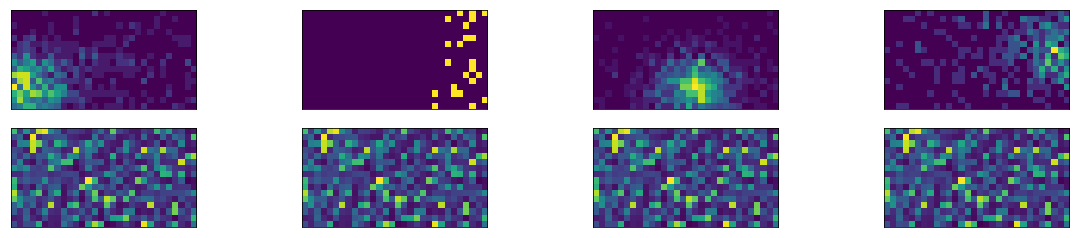

9930


In [20]:
n = 4  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    idea=np.random.randint(1,x_test.shape[0])
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[idea].reshape(30, 16).transpose())
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[idea].reshape(30, 16).transpose())
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
print(idea)



In [21]:
#print(error_prediction)